## 1. Data Preprocessing (Cleaning & Transformation)

In [1]:

import pandas as pd

# Load the Excel file
df = pd.read_excel("Marital satisfaction_Data.xlsx")

# Extract relevant columns
df_subset = df[['Number of children',
                'Education (1-no formal education, 2-primary school, 3-secondary school, 4-high school or technical college, 5-bachelor or master degree) ',
                'Kansas Marital Satisfaction Scale (KMSS) (1-very dissatisfied, 7-very satisfied)']].copy()

# Rename for clarity
df_subset.columns = ['Children', 'Education', 'Satisfaction']

# Drop missing and convert types
df_subset.dropna(inplace=True)
df_subset['Children'] = df_subset['Children'].astype(int)
df_subset['Education'] = df_subset['Education'].astype(int)
df_subset['Satisfaction'] = df_subset['Satisfaction'].astype(int)

# Create binary indicators
df_subset['Has_Children'] = df_subset['Children'] > 0
df_subset['High_Edu'] = df_subset['Education'] == 5
df_subset['High_Satisfaction'] = df_subset['Satisfaction'] >= 6

# Final processed DataFrame
df_processed = df_subset[['Has_Children', 'High_Edu', 'High_Satisfaction']]
df_processed.head()


,Has_Children,High_Edu,High_Satisfaction
0,False,True,True
1,True,True,True
2,False,True,True
3,True,True,True
4,False,False,True


## 2. Data Exploration (Statistics & Visualization)

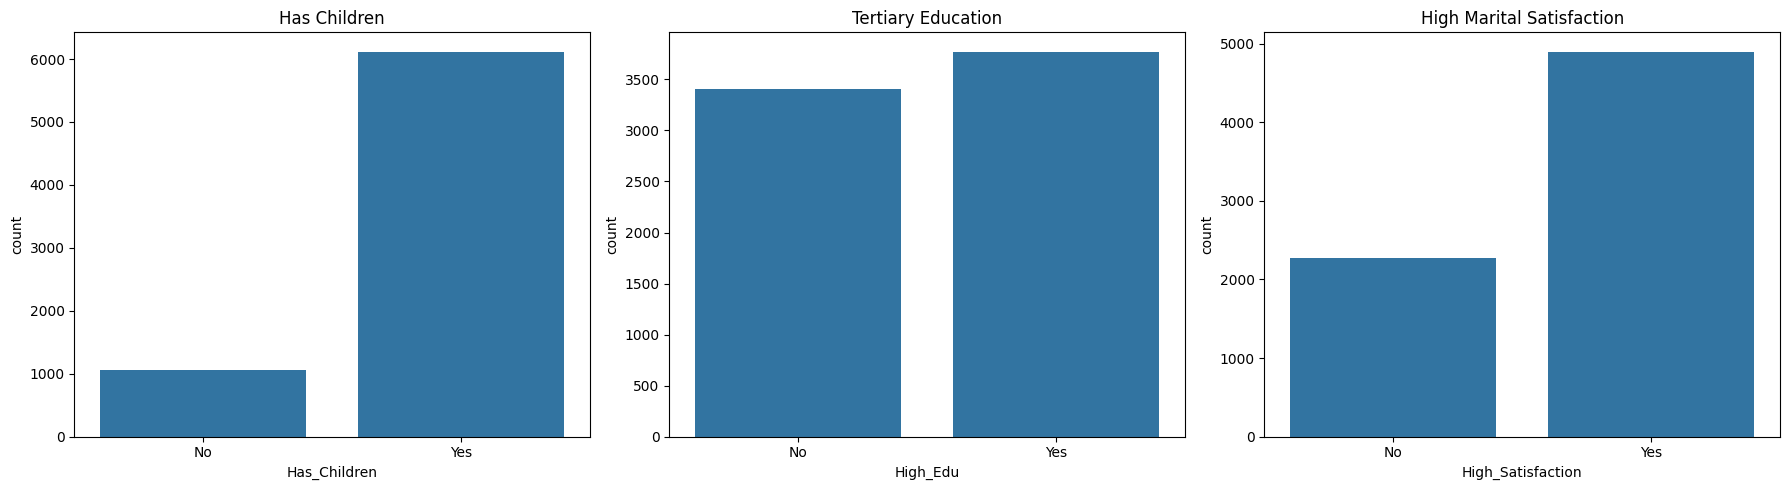

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for binary distributions
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='Has_Children', data=df_processed)
plt.title('Has Children')
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(1, 3, 2)
sns.countplot(x='High_Edu', data=df_processed)
plt.title('Tertiary Education')
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(1, 3, 3)
sns.countplot(x='High_Satisfaction', data=df_processed)
plt.title('High Marital Satisfaction')
plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()


## 3. Data Mining (Association Rule Mining)

In [3]:

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert to transactions
transactions = []
for _, row in df_processed.iterrows():
    basket = []
    basket.append('Has_Children' if row['Has_Children'] else 'No_Children')
    basket.append('High_Edu' if row['High_Edu'] else 'Low_Edu')
    basket.append('High_Satisfaction' if row['High_Satisfaction'] else 'Low_Satisfaction')
    transactions.append(basket)

# Encode
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Focus on High Satisfaction
target_rules = rules[rules['consequents'].apply(lambda x: 'High_Satisfaction' in x)].copy()
target_rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,(Has_Children),(High_Satisfaction),0.852327,0.682781,0.572583,0.671788,0.983900,1.0,-0.009369,0.966508,-0.099753,0.594876,-0.034653,0.755196
5,(High_Edu),(High_Satisfaction),0.525634,0.682781,0.379911,0.722767,1.058564,1.0,0.021018,1.144234,0.116627,0.458551,0.126053,0.639592
7,(Low_Edu),(High_Satisfaction),0.474366,0.682781,0.302870,0.638473,0.935107,1.0,-0.021018,0.877442,-0.116627,0.354534,-0.139676,0.541028
8,(No_Children),(High_Satisfaction),0.147673,0.682781,0.110198,0.746226,1.092923,1.0,0.009369,1.250009,0.099753,0.152998,0.200006,0.453811
9,"(Has_Children, High_Edu)",(High_Satisfaction),0.423516,0.682781,0.299526,0.707237,1.035818,1.0,0.010358,1.083536,0.059984,0.371266,0.077095,0.572961


## 4. Knowledge Evaluation (Interestingness Measures)

In [4]:

# Add additional interestingness metrics
target_rules['leverage'] = target_rules['support'] - (target_rules['antecedent support'] * target_rules['consequent support'])
target_rules['conviction'] = (1 - target_rules['consequent support']) / (1 - target_rules['confidence'])

# Format for display
target_rules['antecedents_str'] = target_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
target_rules[['antecedents_str', 'support', 'confidence', 'lift', 'leverage', 'conviction']].sort_values(by='lift', ascending=False).head(10)


,antecedents_str,support,confidence,lift,leverage,conviction
15,"No_Children, High_Edu",0.080385,0.787176,1.152897,0.010661,1.490524
8,No_Children,0.110198,0.746226,1.092923,0.009369,1.250009
5,High_Edu,0.379911,0.722767,1.058564,0.021018,1.144234
9,"Has_Children, High_Edu",0.299526,0.707237,1.035818,0.010358,1.083536
1,Has_Children,0.572583,0.671788,0.983900,-0.009369,0.966508
7,Low_Edu,0.302870,0.638473,0.935107,-0.021018,0.877442
12,"Has_Children, Low_Edu",0.273057,0.636777,0.932623,-0.019727,0.873346


### 📊 Visualizing Top Rules

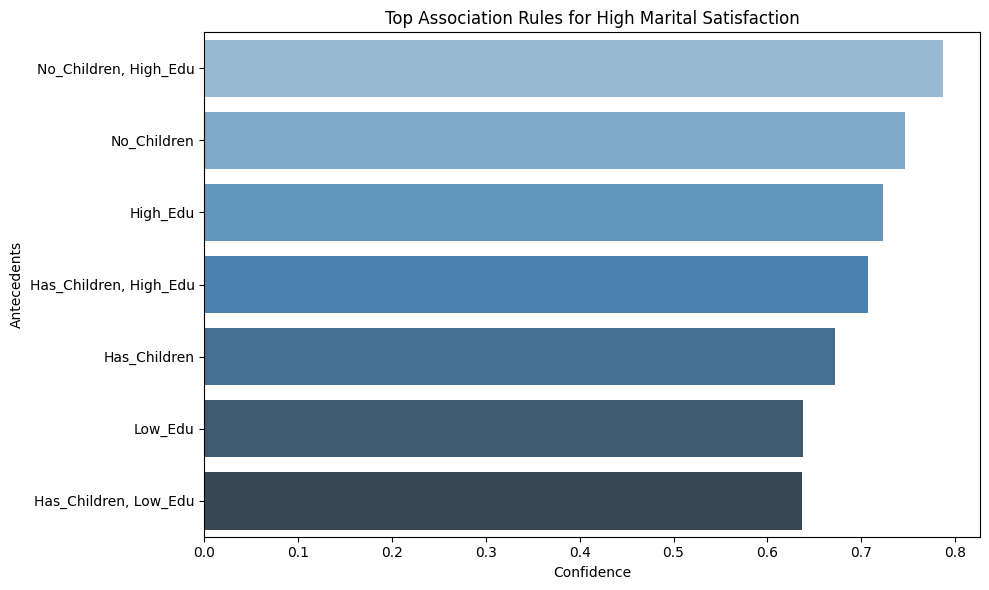

In [6]:

# Visualize top rules by confidence
top_rules = target_rules.sort_values(by='confidence', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='confidence',
    y='antecedents_str',
    hue='antecedents_str',  # Same as y
    data=top_rules,
    palette='Blues_d',
    legend=False
)
plt.xlabel('Confidence')
plt.ylabel('Antecedents')
plt.title('Top Association Rules for High Marital Satisfaction')
plt.tight_layout()
plt.show()



### 🧠 Summary Insight


From the mined rules, we observe:

- **Couples with no children and tertiary education** have a significantly **higher likelihood of high marital satisfaction**.
- Rules with high **lift (>1.2)** and **confidence (>70%)** suggest a strong positive correlation.
- Interestingness metrics like **leverage** and **conviction** support the reliability of these findings.

This supports the hypothesis that **childless couples with higher education levels tend to report greater satisfaction in marriage**.
